# Simple neural network from scratch

In [81]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dropout, Dense, Activation, Conv2D, MaxPooling2D, Flatten

from keras.optimizers import SGD
from keras import backend as K

import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

# image processing 
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from scipy.misc import imresize
import matplotlib.image as mpimg
import io
import urllib

# Load data

In [77]:

############# RUNNING LOCALLY: Read in data FROM FILE ################

# train = pd.read_csv('../data/train_data_with_sampling.csv')
# test = pd.read_csv('../data/test_data.csv')

############# FOR AWS: Read in data FROM GITHUB ################

train = pd.read_csv('https://raw.githubusercontent.com/nikhilaravi/movies/master/data/train_data_with_sampling.csv')
test = pd.read_csv('https://raw.githubusercontent.com/nikhilaravi/movies/master/data/test_data.csv')

############# Convert to test and train set ################

X_train_ids = train[['tmdb_id']].values
y_train = train[['group1', 'group2', 'group3', 'group4', 'group5', 'group6', 'group7']].as_matrix()
X_test_ids = test[['tmdb_id']].values
y_test = test[['group1', 'group2', 'group3', 'group4', 'group5', 'group6', 'group7']].as_matrix()

############## Function to read poster image from github given tmdb id ###################

def loadImageFromId(tmdb_id):
    url = 'https://raw.githubusercontent.com/nikhilaravi/movies/master/posters/' + tmdb_id + '.jpg'
    file = io.BytesIO(urllib.request.urlopen(url).read())
    img = Image.open(file)
    return img

############# Load in posters ################

def load_posters_from_ids(id_array, n, y):
    
    ### Use these three lines to subset the training and testing data when running locally (can't loac 7000 images)
    
    # start = np.random.choice(range(len(id_array)-n))
    # end = start + n
    # Y = y[:n]
    Y = y
    posters = []
    ids = []
    errors = 0
    
    for poster in id_array:
        
        # uncomment this line if running on AWS 
        img = loadImageFromId(str(int(poster[0])))
        
        # uncomment this line if running locally
#         img = Image.open('../posters/' + str(int(poster[0])) + '.jpg') 
        
        try:
            scaled = img.resize(size=(500, 741))
            posters.append(np.asarray(scaled))
            ids.append(poster)
            
        except ValueError:
            errors +=1
            continue
            
    posters_array = np.asarray(posters)
    X = np.array(posters_array)
    
    print ('posters shape: ', X.shape)
    print ('errors: ', errors)
    
    return X, Y

In [7]:
#### load testing and training data 

X_train, Y_train = load_posters_from_ids(X_train_ids, 500, y_train)
X_test, Y_test = load_posters_from_ids(X_test_ids, 100, y_test)

posters shape:  (500, 741, 500, 3)
errors:  0
posters shape:  (100, 741, 500, 3)
errors:  0


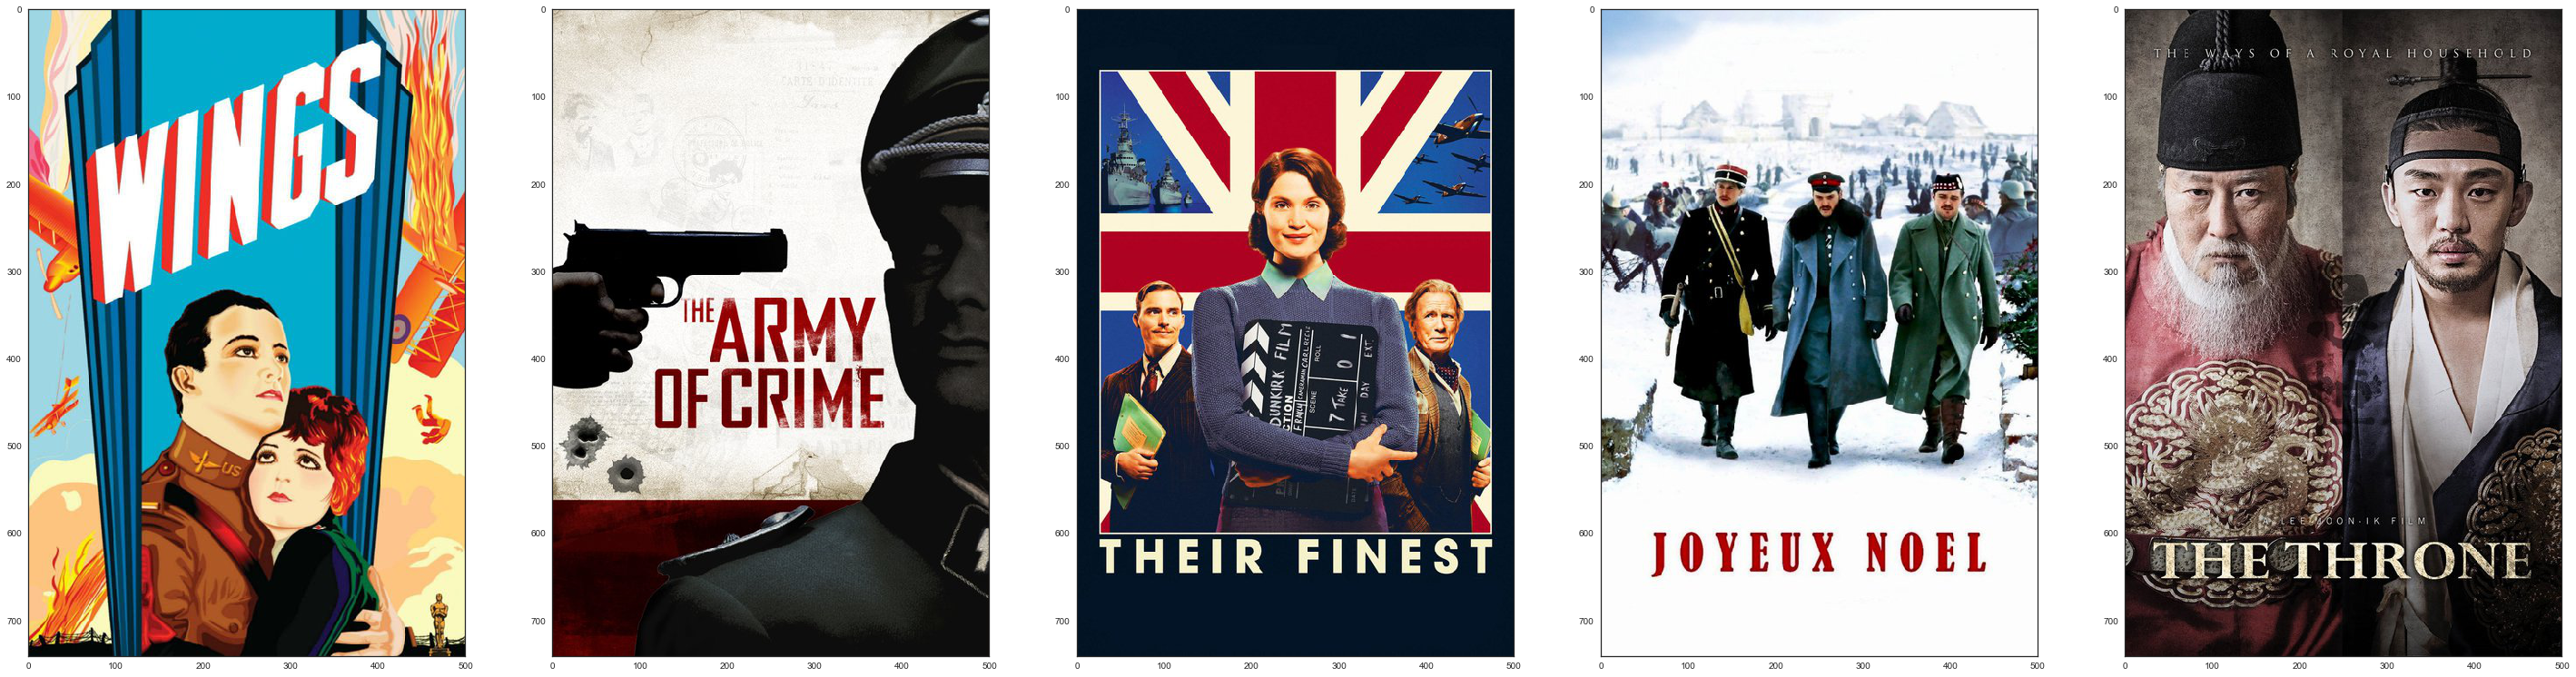

In [38]:
############# Visualise first 5 images of training set ################

plt.figure(figsize=(50,50))
for i in range(1,6):
    plt.subplot(1, 5, i)
    plt.imshow(X_train[i])

# 3 conv max pool layers and 2 fully connected output layers

In [29]:
n_out = 7

####### Model ##########

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(741, 500, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# output is a 3D feature map (height, width, features)

# add two fully connected output layers

model.add(Flatten()) # 1D feature vector
model.add(Dense(units=64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(units=n_out, kernel_initializer='uniform', activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
             optimizer='adam')

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 739, 498, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 246, 166, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 244, 164, 32)      9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 122, 82, 32)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 120, 80, 64)       18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 60, 40, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 153600)            0         
__________

In [52]:
# use a data generator to scale the images (pixel values)
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 50
epochs = 100
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=(Y_train.shape[0])/batch_size,
                    epochs=epochs,
                    verbose=1)
model.save_weights('simple_model.h5')

Epoch 1/1
4/3 [======================================] - 49s - loss: 3.7785 - val_loss: 3.8684


In [32]:
# These are how we measure error - Haming Loss, % exact matches and % at-least-one match
from sklearn.metrics import hamming_loss

def error_measures(ypred, ytest):
    ypred = np.array(ypred)
    ytest = np.array(ytest)
    
    # Hamming loss
    h_loss = hamming_loss(ytest, ypred)

    # Percent exact matches
    y_pred_str = np.array([str(yi) for yi in ypred])
    y_test_str = np.array([str(yi) for yi in ytest])
    percent_exact = np.sum(y_pred_str == y_test_str) * 1. / ytest.shape[0]
    
    # Percent at least one match (at least one of the genres are both 1)
    atleastone_count = 0
    for ind in range(len(ypred)):
        yi_pred = ypred[ind]
        yi_test = ytest[ind]
        for i in range(len(yi_pred)):
            if yi_pred[i] == 1 and yi_test[i] == 1:
                atleastone_count += 1
                break
    percent_atleastone = atleastone_count * 1. / ytest.shape[0]
    
    return h_loss, percent_exact, percent_atleastone

In [62]:
################# Make predictions on the testing set ###################

y_pred_proba = model.predict_generator(datagen.flow(X_test, Y_test, batch_size=batch_size), 
                                       steps=(Y_test.shape[0])/batch_size)

# Predict after casting probabilities to labels
y_pred = []
for yi in y_pred_proba:
    yi_new = np.array([1 if yii >= 0.5 else 0 for yii in yi])
    y_pred.append(yi_new)
y_pred = np.array(y_pred)

In [80]:
# compute error measures
h_loss, percent_exact, percent_atleastone = error_measures(y_pred, Y_test)
print ('CNN error measures \n=====================\n')
print ('Hamming Loss: ', h_loss)
print ('Percent exact: ', percent_exact)
print ('Percent at least one: ', percent_atleastone)

In [67]:
######## check number in each class in the training set ############
print ('class counts training: ', np.sum(Y_train, axis=0))
print ('class counts testing: ', np.sum(Y_test, axis=0))
print ('class counts prediction: ', np.sum(y_pred, axis=0))

array([ 500.,  460.,    2.,    9.,  103.,  216.,   46.])